In [34]:
from Trainer import SerotoninESNTrainer
import mne 
import matplotlib.pyplot as plt 
import numpy as np 
from reservoirpy.nodes import ESN 

In [35]:
schizophrenic_epochs = mne.read_epochs(
    '../processed_schizophrenic_eeg-epo.fif', preload=True)

Reading d:\research-reservoir\Schizo-hormone\Serotonin-based\..\processed_schizophrenic_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
15819 matching events found
No baseline correction applied
0 projection items activated


In [36]:
data = schizophrenic_epochs.get_data()

C:\Users\anisr\AppData\Local\Temp\ipykernel_6904\2159550794.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = schizophrenic_epochs.get_data()


In [37]:
print(data.shape)
all_channels = schizophrenic_epochs.ch_names
n_epochs, n_channels, n_times = data.shape

(15819, 19, 500)


In [38]:
frontal_lobe_channels = [i for i, ch in enumerate(all_channels) if ch in [
    'F3', 'F4', 'F7', 'F8', 'Fz']]
mPFC_channels = [i for i, ch in enumerate(
    all_channels) if ch in ['Fp1', 'Fp2']]
print(frontal_lobe_channels,mPFC_channels)

[1, 6, 10, 13, 16] [0, 5]


In [39]:
from Modulator import SerotoninEEGModulator
serotonin_modulator = SerotoninEEGModulator(histamine_level=0.2)

In [40]:
X_unmodulated = data.reshape(n_epochs, -1)
y_unmodulated = np.roll(X_unmodulated, -1, axis=0)
X_train_unmodulated = X_unmodulated[:-1]
y_train_unmodulated = y_unmodulated[:-1]

In [41]:
X_train_unmodulated = (X_train_unmodulated - np.mean(X_train_unmodulated,
                       axis=0)) / np.std(X_train_unmodulated, axis=0)

In [51]:
esn = ESN(units=10000, sr=0.95, sparsity=0.1, lr=0.6,
          input_scaling=0.5, input_shift=0.0)
esn.fit(X_train_unmodulated, y_train_unmodulated)

Running ESN-5: 100%|██████████| 1/1 [08:21<00:00, 501.07s/it]


Fitting node ESN-5...


'ESN-5': ESN('Reservoir-5', 'Ridge-5')

In [52]:
serotonin_levels = np.linspace(0, 1, 5)
n_predictions = 100

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(actual_data, predicted_data):
    mse = mean_squared_error(actual_data, predicted_data)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_data, predicted_data)
    r2 = r2_score(actual_data, predicted_data)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    }

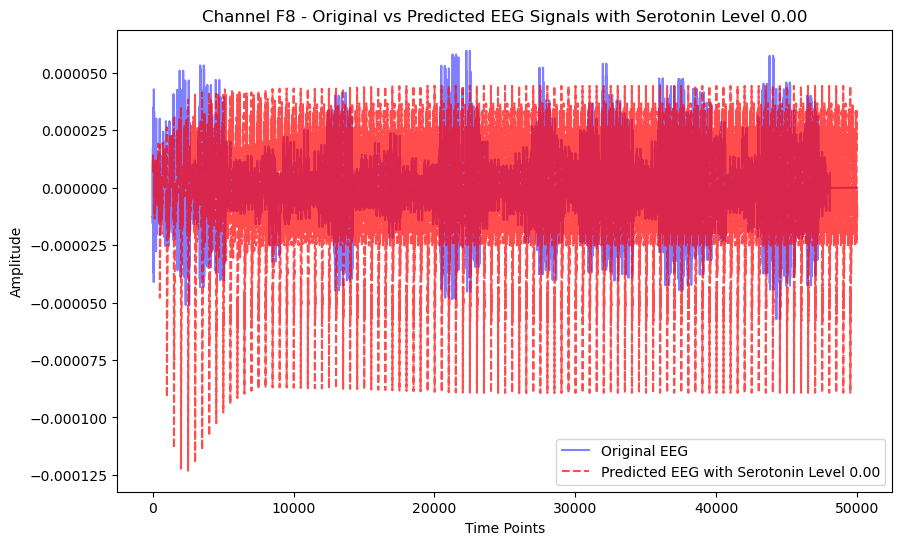

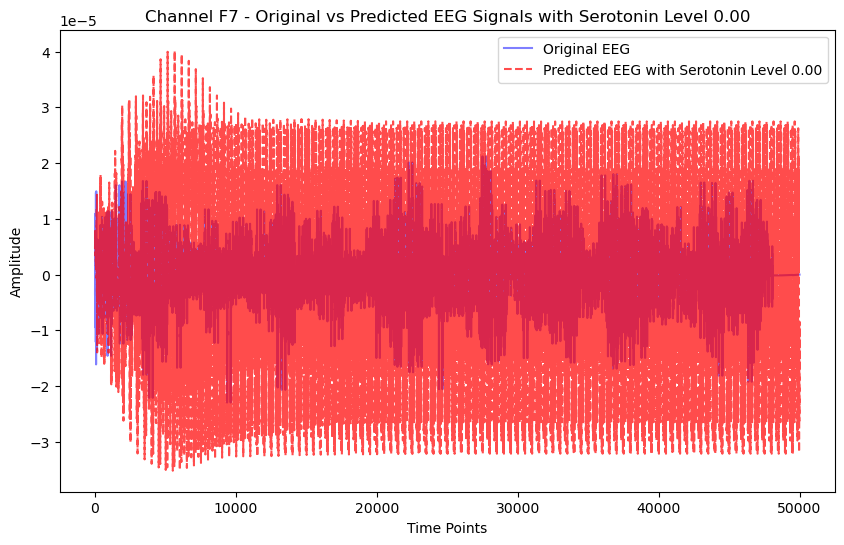

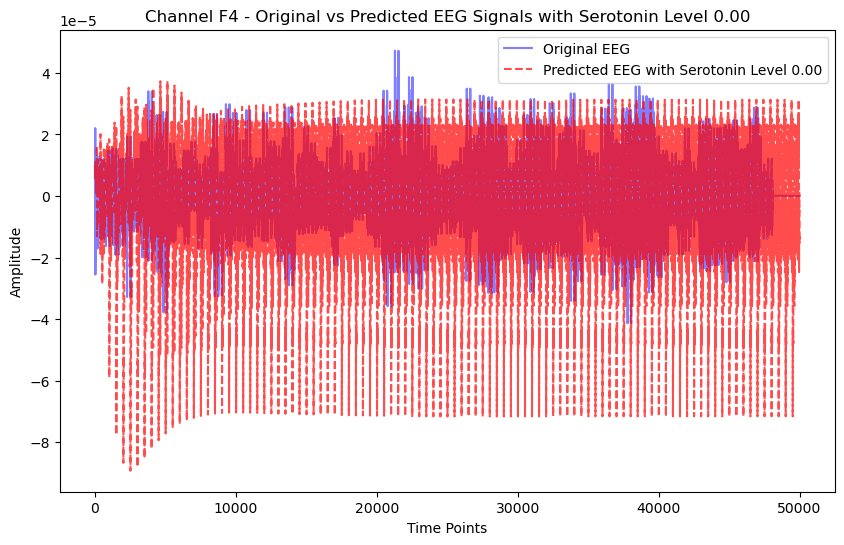

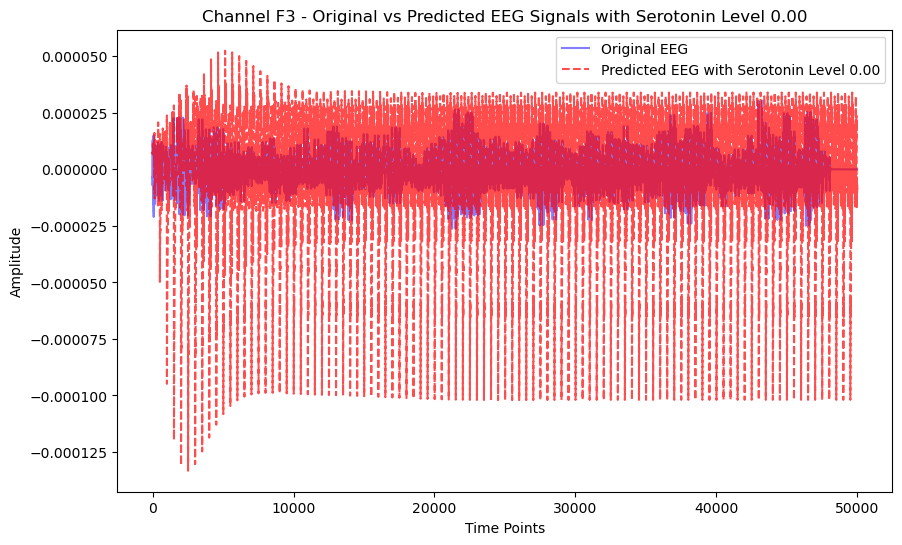

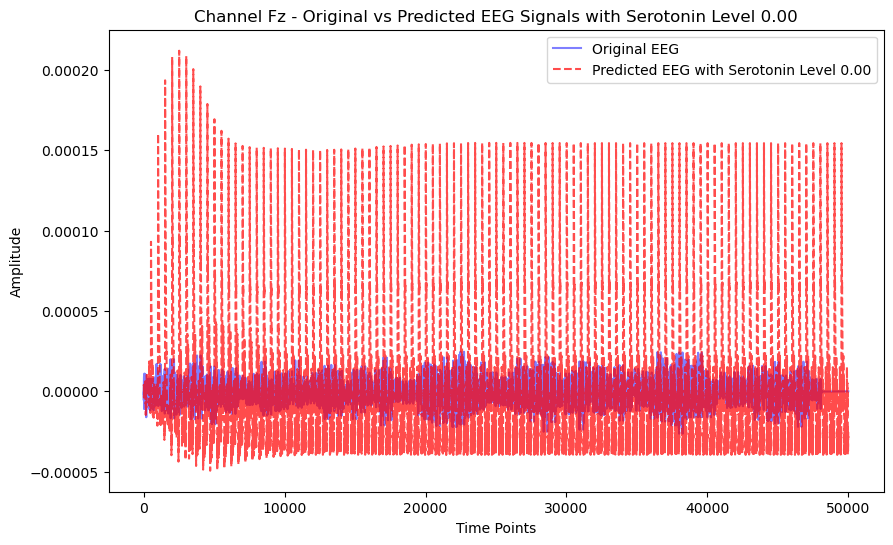

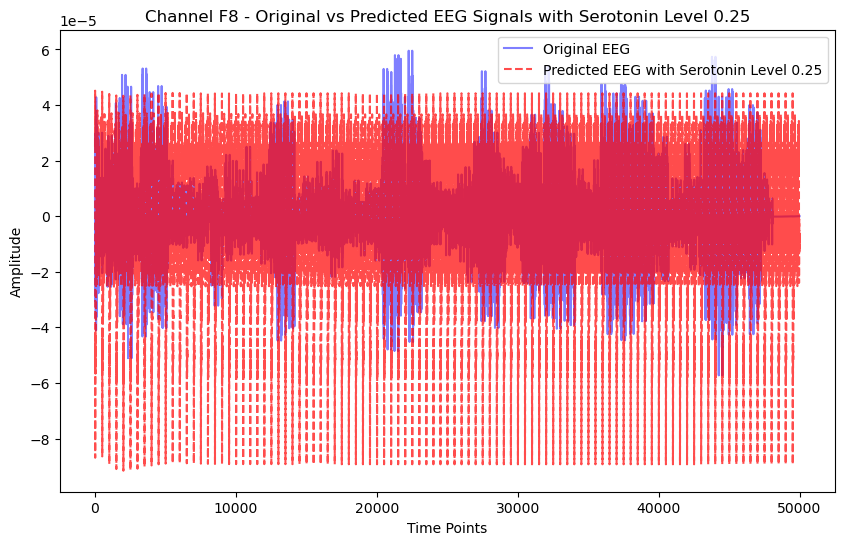

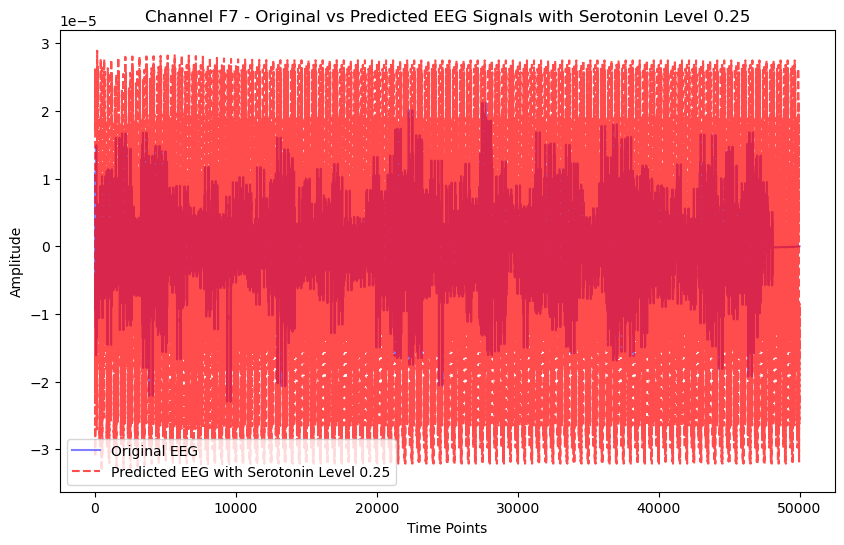

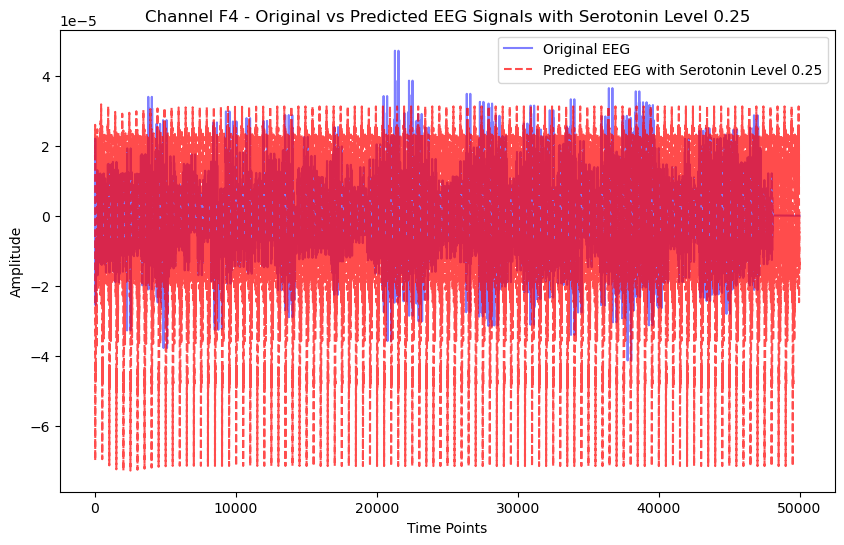

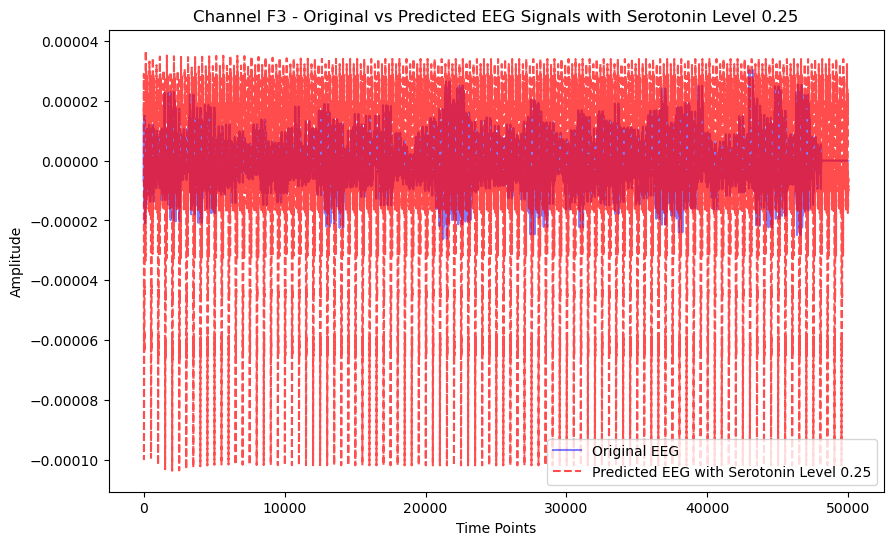

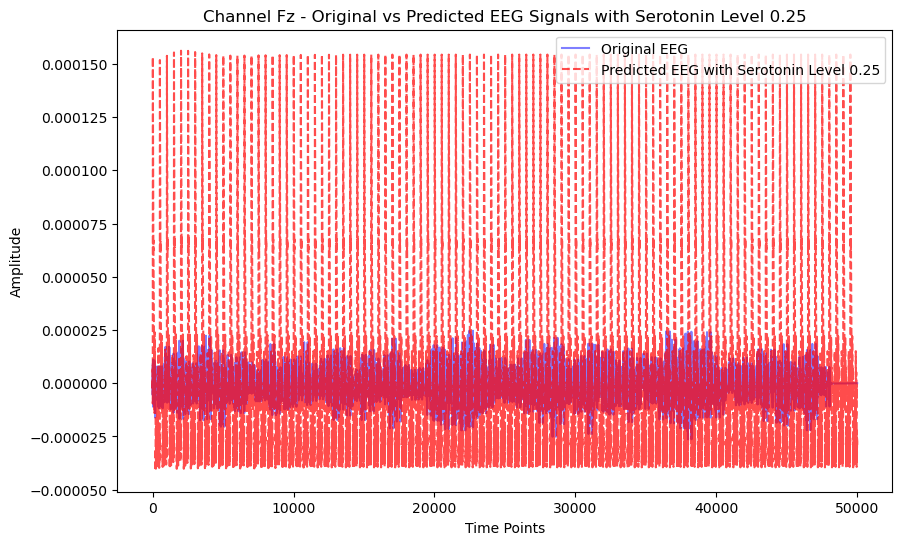

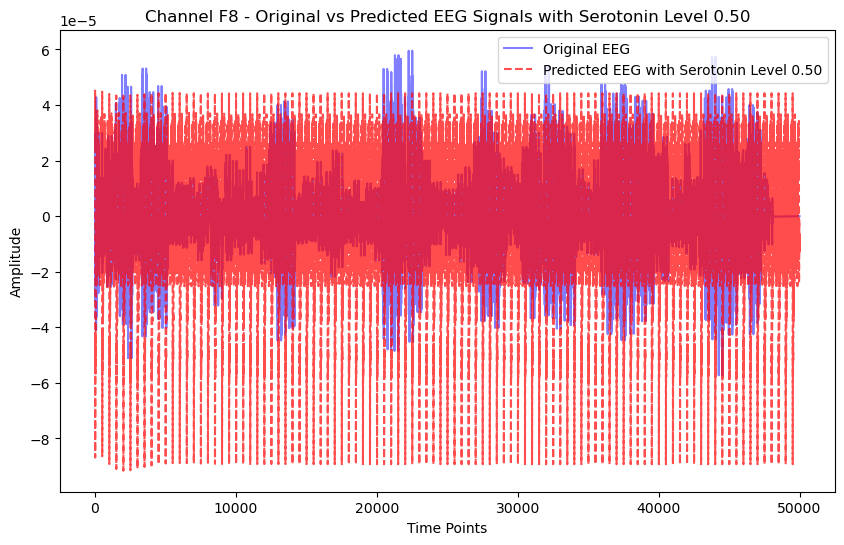

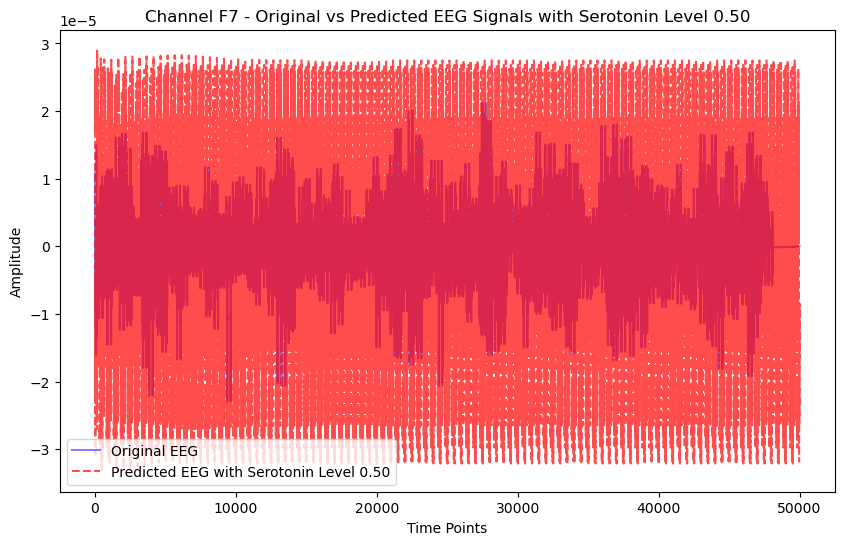

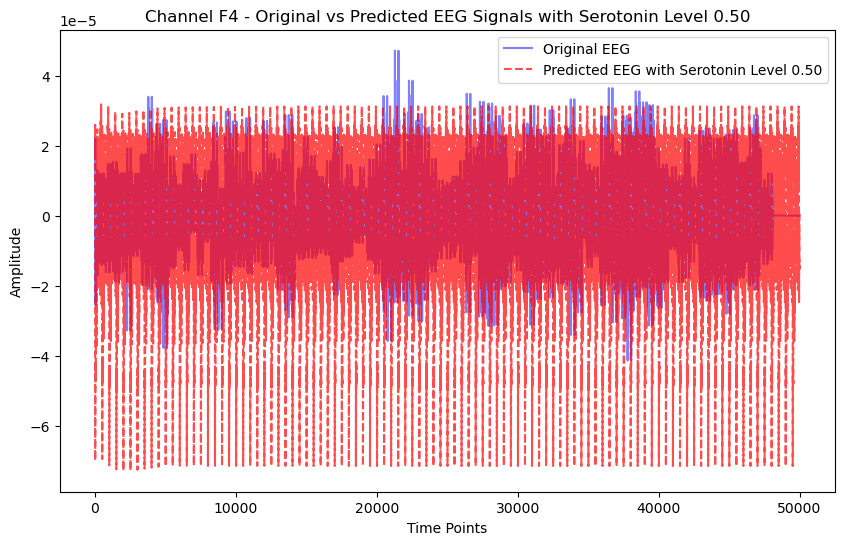

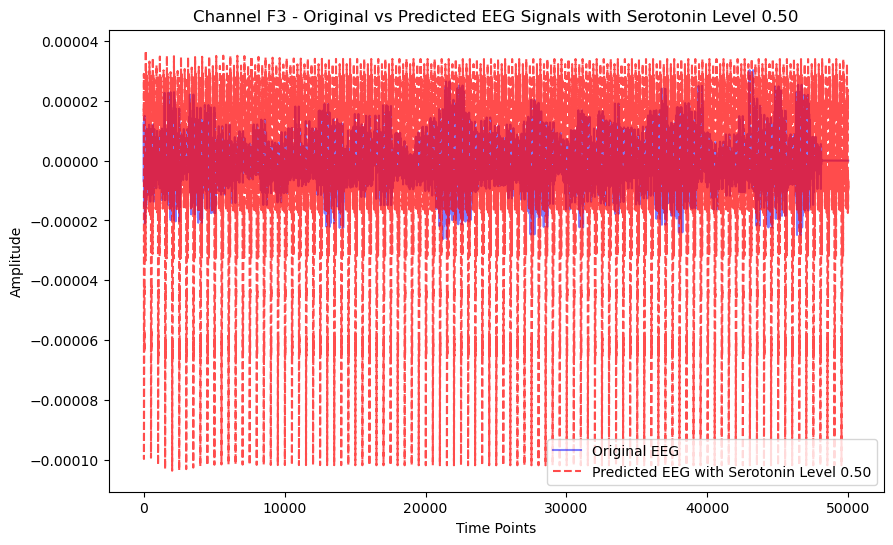

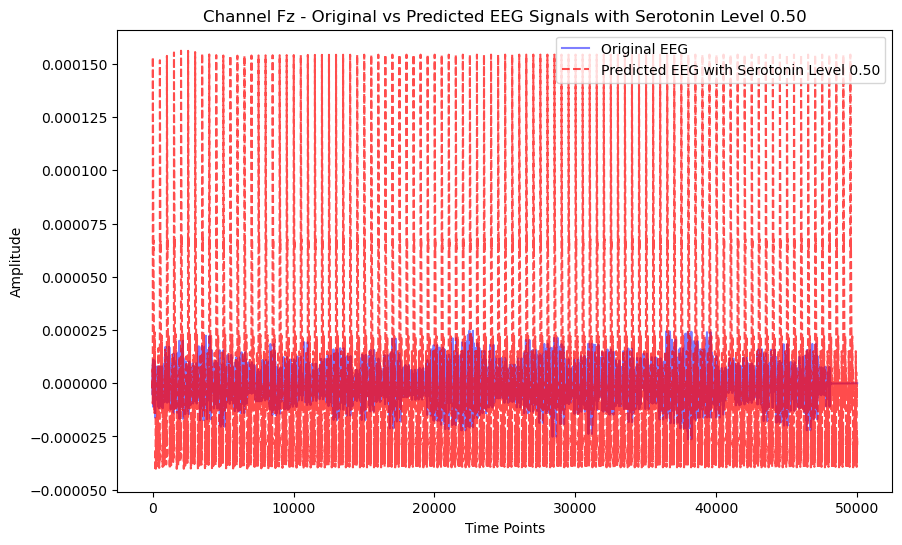

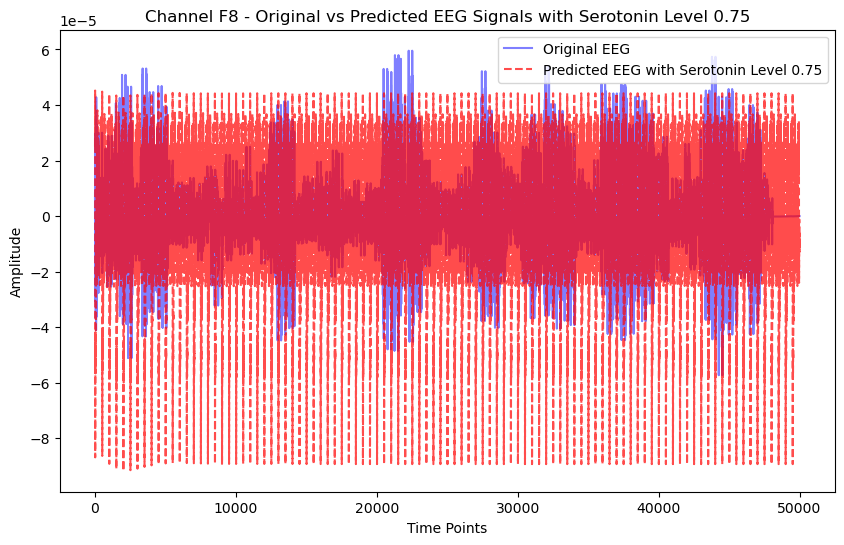

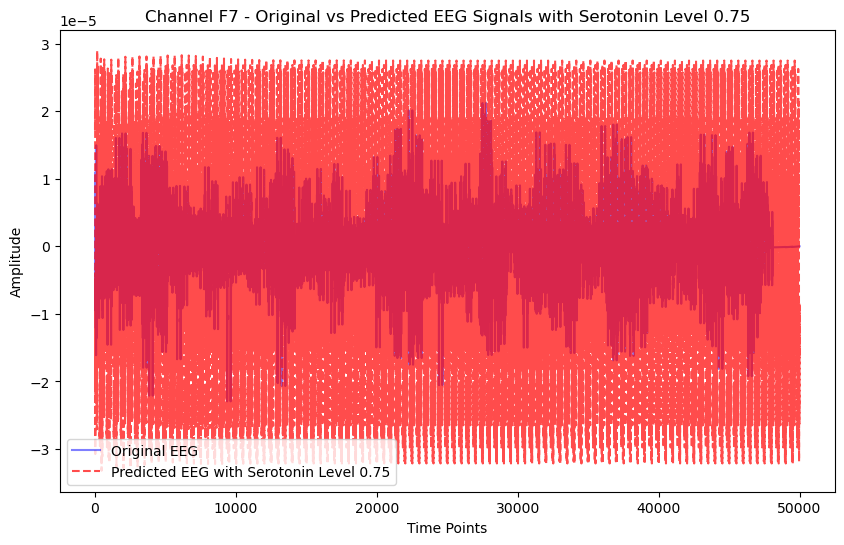

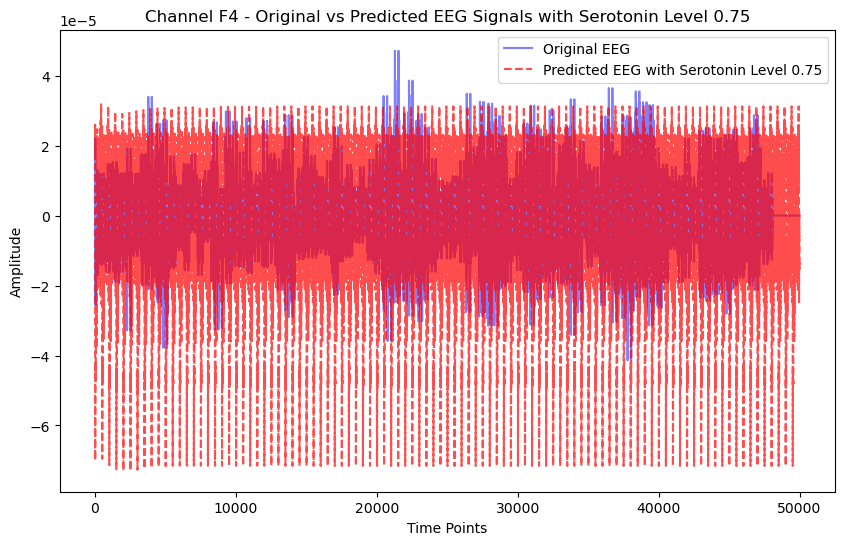

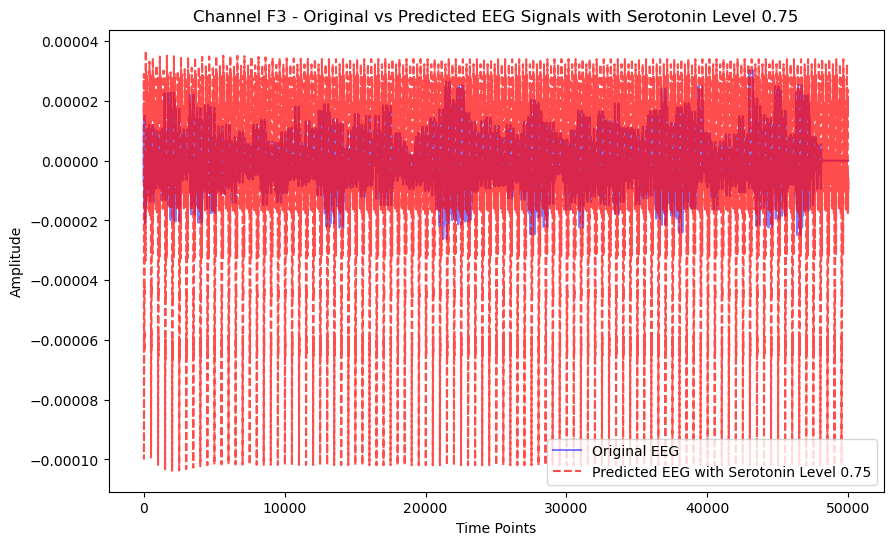

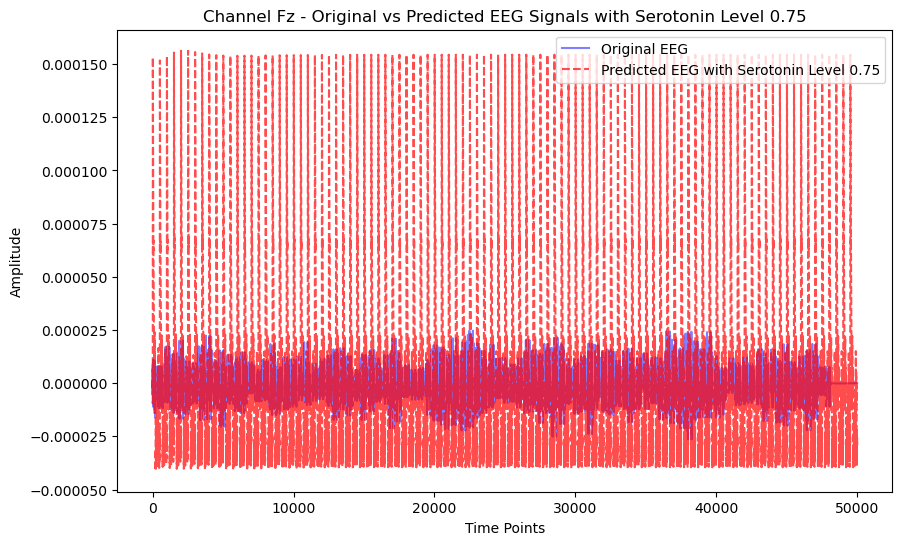

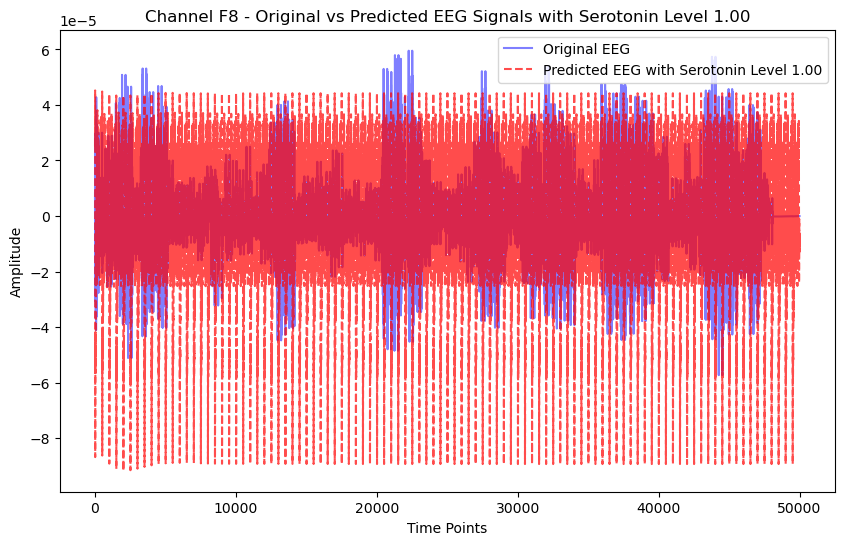

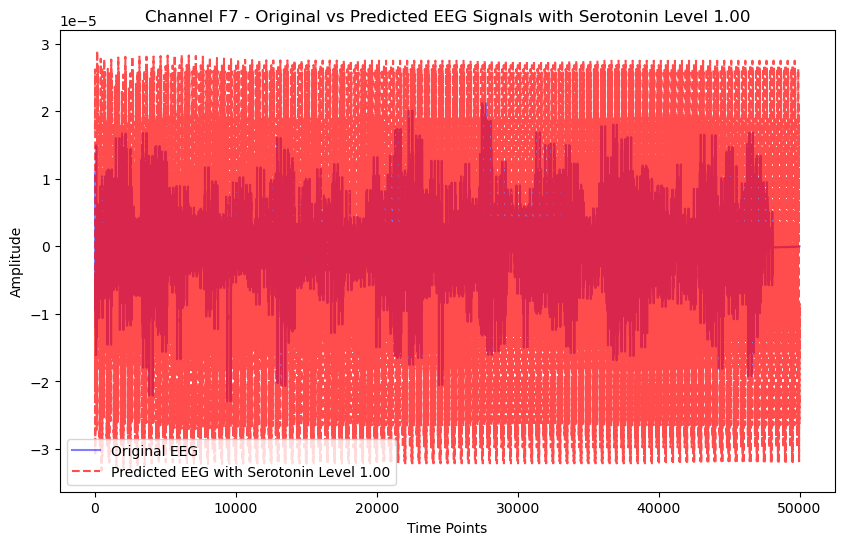

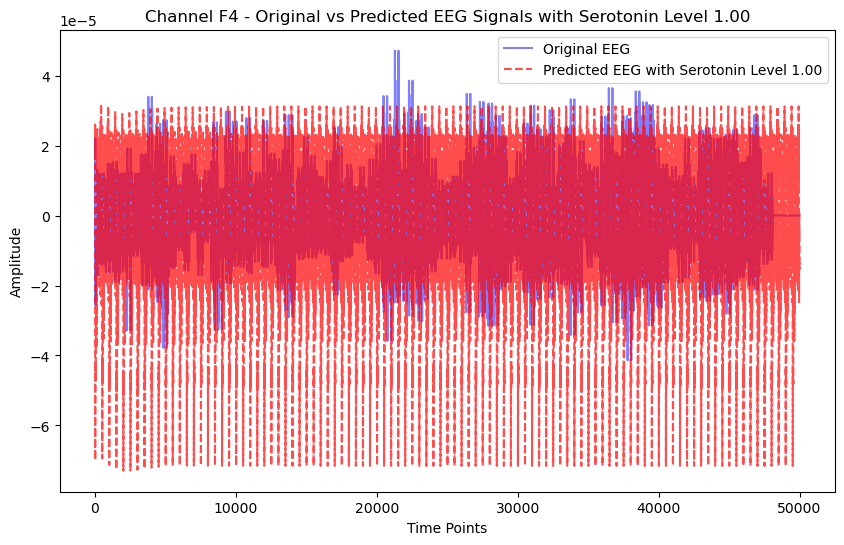

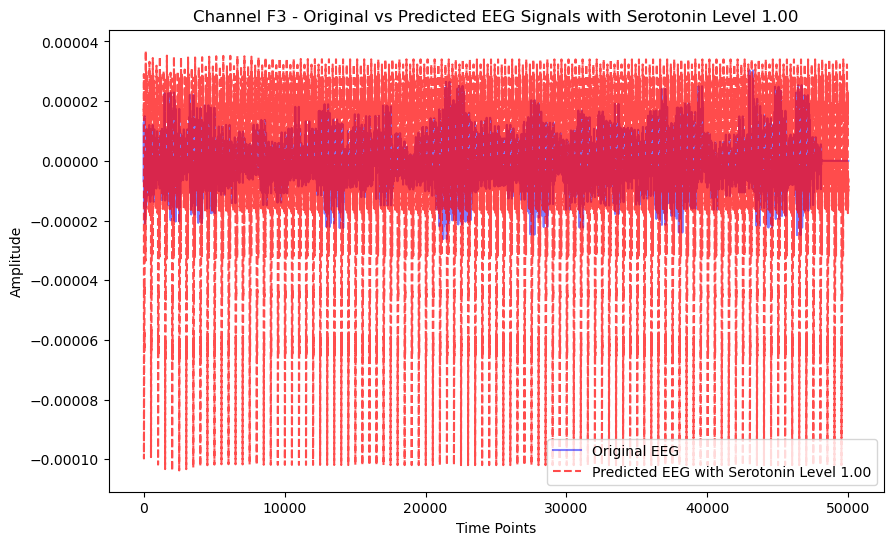

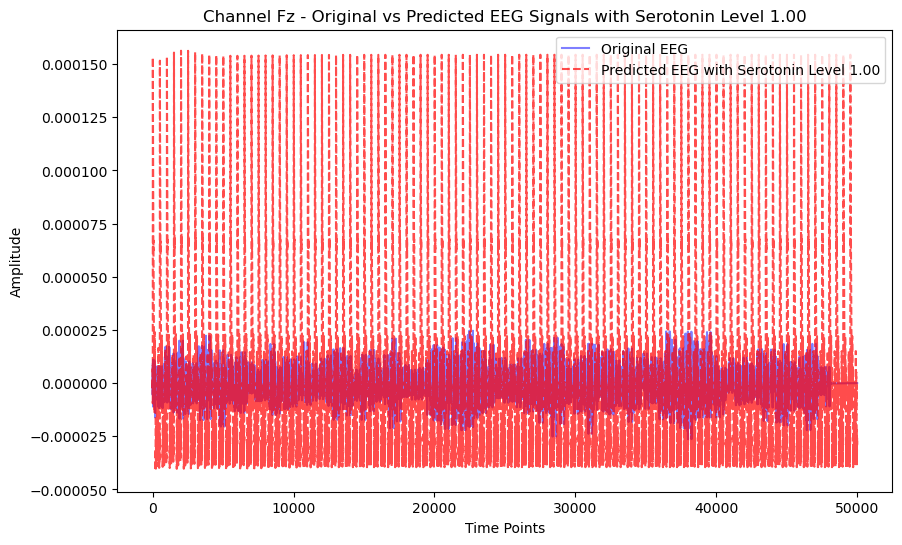

In [54]:
for level in serotonin_levels:
    serotonin_modulator.serotonin_level = level
    modulated_eeg_data = serotonin_modulator.modulate(data,all_channels)

    # Prepare modulated data for prediction
    X_modulated = modulated_eeg_data.reshape(n_epochs, -1)
    last_known_epoch = X_modulated[-1].reshape(1, -1)
    predictions = []
    current_input = last_known_epoch

    for _ in range(n_predictions):
        next_prediction = esn(current_input)
        predictions.append(next_prediction.flatten())
        current_input = next_prediction

    # Convert predictions to the original EEG shape
    future_predictions = np.array(predictions).reshape(
        n_predictions, n_channels, n_times)

    # Plot the original vs predicted signals for frontal lobe channels
    for ch_index in frontal_lobe_channels:
        plt.figure(figsize=(10, 6))
        plt.plot(data[-n_predictions:, ch_index, :].flatten(),
                 label='Original EEG', color='blue', alpha=0.5)
        plt.plot(future_predictions[:, ch_index, :].flatten(
        ), label=f'Predicted EEG with Serotonin Level {level:.2f}', color='red', linestyle='--', alpha=0.7)
        plt.title(
            f'Channel {all_channels[ch_index]} - Original vs Predicted EEG Signals with Serotonin Level {level:.2f}')
        plt.xlabel('Time Points')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

In [55]:
evaluation_metrics = evaluate_model(
    actual_data_selected.flatten(), predicted_data_selected.flatten())
print(evaluation_metrics)

{'MSE': 0.0017535074393255625, 'RMSE': 0.04187490226048966, 'MAE': 0.027264019977361827, 'R-squared': -0.001889781044021488}
